##### Note
Allign tables to the left

In [1]:
%%html
<style>
table {float:left}
</style>

# Evaluation of models
basic, spatial, temporal and spatial-temporal evaluation of the error terms

## Contents:
    1. Load in data and initialise the GeoDataFrame
    2. Model evaluation (basic)
    3. Spatial evaluation
    4. Temporal evaluation  
    5. *POTENTIALLY: Spatial-temporal evaluation -> containing ST-KDE of points*



| Number | Purpose    |
|--------|------------|
| 0      | Leisure    |
| 1      | Food/Drink |
| 2      | Shops      |
| 3      | Pick-up/Drop-off    |
| 4      | Education |
| 5      | Health      |


In [2]:
import pandas as pd
import geopandas as gpd
import shapely
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime
import sklearn.metrics
import geoplot
import splot # spatial plotting
import pysal as ps
import statsmodels.tsa
import stldecompose # import statsmodels.tsa.seasonal

import pointpats

sns.set_style('white')
%matplotlib inline

/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/pysal/model/spvcm/abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


# 1. Load in data and turn into GeoDataFrame
In this section, we load in the prediction data and shapefiles used to plot the data.
We also define the global variables used in the notebooks

## Load in data

In [3]:
# predictions
predictions_17 = pd.read_csv('../../Data/model_outputs/predictions_17.csv')

mtl_region = gpd.read_file("../../Data/shapes/mtl_regions.json", crs='EPSG:3347')
mtl_dissem = gpd.read_file("../../Data/shapes/mtl_dissem.geojson", crs='EPSG:3347')
city_of_montreal = mtl_region.loc[(mtl_region.AIRE > 0) & (mtl_region.TYPE == 'Arrondissement')]

In [4]:
predictions_17['correct'] = predictions_17.apply(lambda row: row['purpose'] == row['prediction'], axis=1)

In [5]:
predictions_17['starttime'] = pd.to_datetime(predictions_17['starttime'])
predictions_17['endtime'] = pd.to_datetime(predictions_17['endtime'])

In [6]:
predictions_17['start_point'] = predictions_17.apply(lambda row: \
                                                     shapely.geometry.Point(row['startx'],row['starty']), axis=1)
predictions_17['end_point'] = predictions_17.apply(lambda row: \
                                                     shapely.geometry.Point(row['endx'],row['endy']), axis=1)

In [7]:
predictions_17_gdf = gpd.GeoDataFrame(predictions_17, geometry='end_point', crs='EPSG:3347')

In [8]:
predictions_17_gdf.head()

id_trip  mode  duration    distance_m  weekday    precip       temp  \
0   150744     2       862   9935.922336        1  0.000000  16.910884   
1   257884     3       110    347.261519        1  0.000062  26.659408   
2   410129     2       569   4605.407008        1  0.000099  25.860051   
3    45863     2      1037  16426.302328        1  0.000099  22.094541   
4   452030     2      1008   6500.370675        1  0.000000  18.627913   

   morning  midday  afternoon  ...  p_nearby_1  p_nearby_2  p_nearby_3  \
0        1       0          0  ...    0.033333    0.766667    0.033333   
1        0       0          0  ...    0.000000    0.250000    0.500000   
2        0       0          0  ...    0.000000    0.000000    0.000000   
3        0       0          0  ...    0.071429    0.357143    0.000000   
4        0       1          0  ...    0.000000    1.000000    0.000000   

   p_nearby_4  p_nearby_5           starttime             endtime  correct  \
0    0.033333    0.000000 2017-09-18 10:02:50 2017-09-18 10:17:12    False   
1    0.000000    0.000000 2017-09-18 20:50:10 2017-09-18 20:52:00     True   
2    0.000000    0.000000 2017-09-18 21:20:24 2017-09-18 21:29:53    False   
3    0.142857    0.071429 2017-09-19 00:40:14 2017-09-19 00:57:31    False   
4    0.000000    0.000000 2017-09-19 11:48:18 2017-09-19 12:05:06    False   

                                   start_point  \
0  POINT (7624322.265039734 1247672.970059557)   
1  POINT (7630553.739398136 1250138.737725165)   
2   POINT (7657929.669970571 1259673.66130353)   
3  POINT (7621400.895912292 1240840.373705331)   
4  POINT (7619971.046717097 1249126.502040465)   

                                     end_point  
0  POINT (7631863.767736511 1250414.940902894)  
1  POINT (7630828.451089671 1250138.426722821)  
2   POINT (7658376.02959057 1256748.135254442)  
3  POINT (7628634.725755887 1250061.214220126)  
4  POINT (7615643.478397049 1247517.559389279)  

[5 rows x 29 columns]

## Global Variables
Define variables which are used in multiple places

In [9]:
## for converting purpose factor number back to purpose name
PURPOSE_CLASSES = {0:'leisure', 1:'food_drink', 2:'shops', 3:'pick_up_drop_off',  4:'education', 5:'health'}
LONG_NAMES = ['Leisure','Food & drink','Shopping','Pick-up/drop-off','Education','Health']
SHORT_NAMES = ['Leisure','Food','Shop','P.u./D.o.','Education','Health']

## for plotting Montreal
MIN_LON = predictions_17.endx.min() - 1000
MAX_LON = predictions_17.endx.max() + 1000
MIN_LAT = predictions_17.endy.min() - 1000
MAX_LAT = predictions_17.endy.max() + 1000

## for general plotting
COLOUR_MAP = 'Blues'
COLOURBLIND_PALETTE = ["#7b85d4","#f37738","#83c995","#d7369e","#c4c9d8","#859795","#e9d043","#ad5b50", "#ffa07a", "k"]
MARKER_TYPES = ['s','o', '*']

## true and prediction labels
TRUE_LABELS = predictions_17['purpose']
PREDICTION_LABELS = predictions_17['prediction']

# observed accuracy == our model's accuracy
OBSERVERD_ACCURACY = sklearn.metrics.accuracy_score(PREDICTION_LABELS, TRUE_LABELS)
print("Accuracy =", OBSERVERD_ACCURACY)

Accuracy = 0.5492417639881472


# 2. Basic model evaluation
In this section, we carry out non-spatial and non-temporal evaluation of the model. We explore the failures of the model for each class

### Contents:
    2.1. Confusion matrix  
    2.2. Stacked bar charts  
    2.3. Evaluation statistics
    
#### Other ideas:
    2.4. Multi-class Precision-recall curves

  
References:  
https://medium.com/apprentice-journal/evaluating-multi-class-classifiers-12b2946e755b

## 2.1 Confusion matrix
Visualisation of a confusion matrix of the predictions

In [10]:
def plot_confusion_matrix(conf_matrix, mpl_kwargs):
    """
        function for plotting a confusion matrix as a heatmap
        -------------------------
        :params conf_matrix: (N*N numpy.array) Confusion matrix to plot
        :return ax: (matplotlib.pyplot.figure.axes) the axes of the figure so it can be saved as an image or edited
    """
    # plot this confusion matrix 
    fig, ax = plt.subplots(1,figsize=(9,7))
    # main plot
    sns.heatmap(conf_matrix, annot=True, annot_kws={'size':14}, **mpl_kwargs)
    # styling
    plt.xticks(np.arange(len([0,1,2,3,4,5]))+0.5, labels=SHORT_NAMES, size=14);
    plt.yticks(np.arange(len([0,1,2,3,4,5]))+0.5, labels=SHORT_NAMES, size=14, va='center');
    plt.xlabel('Predicted',size=20)
    plt.ylabel('Actual',size=20)
    ax.figure.axes[-1].yaxis.label.set_size(20)
    ax.figure.axes[-1].set_yticklabels(ax.figure.axes[-1].get_yticklabels(),fontsize=14);
    plt.title('Random forest estimation of trip purpose', size=20)
    return ax

In [11]:
# create a confusion matrix using sklearn
conf_matrix = sklearn.metrics.confusion_matrix(TRUE_LABELS, PREDICTION_LABELS)
conf_matrix

array([[1381,   32,  529,   13,   51,    6],
       [ 302,   67,  279,    7,   22,    1],
       [ 585,   36, 1240,   23,   43,    4],
       [ 166,    8,   99,   52,   19,    1],
       [  81,    9,   58,    5,  387,    4],
       [  97,    8,   76,   10,   12,   24]])

In [12]:
## create a confusion matrix as a proportion of the actual values
# calculate the ground truths for each column (number of trips for each class) in a format that allows numpy array calculation
ground_truth_values = np.array([sum(row) for row in conf_matrix]).reshape(-1,1)
proportion_of_ground_truth = conf_matrix / ground_truth_values

In [13]:
proportion_of_ground_truth

array([[0.68638171, 0.01590457, 0.26292247, 0.00646123, 0.02534791,
        0.00298211],
       [0.44542773, 0.09882006, 0.41150442, 0.01032448, 0.03244838,
        0.00147493],
       [0.30295184, 0.01864319, 0.64215432, 0.01191093, 0.02226825,
        0.00207147],
       [0.48115942, 0.02318841, 0.28695652, 0.15072464, 0.05507246,
        0.00289855],
       [0.14889706, 0.01654412, 0.10661765, 0.00919118, 0.71139706,
        0.00735294],
       [0.42731278, 0.03524229, 0.33480176, 0.04405286, 0.05286344,
        0.10572687]])

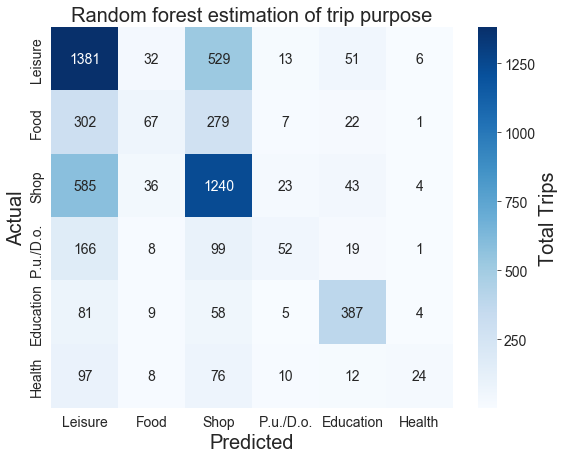

In [14]:
# define the plot styling and specifications
plot_specs = {'cbar_kws':{'label': 'Total Trips'}, 'fmt':'.0f', 'cmap':COLOUR_MAP}

# plot 
ax = plot_confusion_matrix(conf_matrix, mpl_kwargs=plot_specs)

##### Interpretation
    o For every combination of Actual/Predicted there are at least 3 trips
    o For each class the majority predicted is the actual
    o More Shopping trips are misclassified as Health trips compared to all other classes
    o Misclassified Food, Pick-up/drop-off, Education & Health trips are roughly split evenly between Leisure & Shopping trips


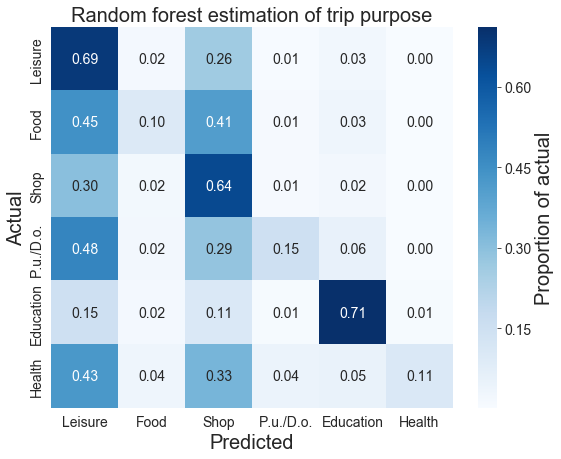

In [15]:
# define the plot styling and specifications
plot_specs = {'cbar_kws':{'label': 'Proportion of actual'}, 'fmt':'.2f', 'cmap':COLOUR_MAP}
# plot
ax = plot_confusion_matrix(proportion_of_ground_truth, mpl_kwargs=plot_specs)

##### Interpretation
    o Leisure and Shoping trips make up a highest relative proportion of the misclassified trips for all the classes. 
    o Education trips are not highly coupled with any other type of trip purpose.
    o Health, Pick-up/drop-off & Food are the 3rd most predicted class after Shops & Leisure trips in each of their respective classes (suggesting class-imbalance may have thrown the model).

## 2.2 Stacked bar charts

In [16]:
def plot_stacked_bar_chart(prediction_matrix, ylabel):
    """
        Function for plotting a stacked bar chart from a list of lists.
        The prediction matrix input will be like: [[first_class_values], [second_class_values]] 
        where first_class_values and second_class_values are lists containing the same amount of numbers
        --------------------
        :params prediction_matrix: (list of lists) a matrix to build the stacked bar chart from
        :params y_label: (string) label for the ylabel of the plot
        :return ax: (matplotlib.pyplot.figure.axes) the axes of the figure so it can be saved as an image or edited
    """
    N = prediction_matrix.shape[0]
    fig, ax = plt.subplots(1, figsize=(8,6))
    ind = np.arange(N)    # the x locations for the groups
    bottom_values = np.array([0.0,0.0,0.0,0.0,0.0,0.0])
    width=0.75
    for cls_i in range(0, N):
        prop_pred = tuple(prediction_matrix[cls_i])
        if cls_i == 0:
            plt.bar(ind, prop_pred, width=width, color=COLOURBLIND_PALETTE[cls_i])
        else:
            plt.bar(ind, prop_pred, width=width, bottom=bottom_values,color=COLOURBLIND_PALETTE[cls_i])
        bottom_values += prop_pred

    # styling
    plt.xticks(size=16)
    plt.yticks(size=16)
    ax.set_xticklabels(['']+SHORT_NAMES)
    ax.set_xlabel('Prediction', size=20)
    ax.set_ylabel('Actual (%)', size=20)
    ax.set_title("Predictions by class", size=20)
    plt.legend(LONG_NAMES,fontsize=16, loc=(1.04,0.4));
    return ax

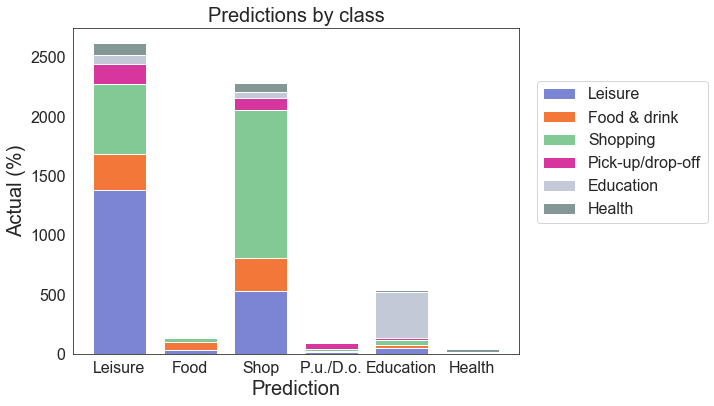

In [17]:
# plot all values
plot_stacked_bar_chart(conf_matrix, ylabel='Actual')

In [18]:
# plot the percentage of each prediction for each class
percentage_prediction_by_class = proportion_of_ground_truth.T * 100
percentage_prediction_by_class

array([[68.63817097, 44.54277286, 30.29518384, 48.11594203, 14.88970588,
        42.73127753],
       [ 1.59045726,  9.8820059 ,  1.86431901,  2.31884058,  1.65441176,
         3.52422907],
       [26.29224652, 41.15044248, 64.21543242, 28.69565217, 10.66176471,
        33.48017621],
       [ 0.64612326,  1.03244838,  1.1910927 , 15.07246377,  0.91911765,
         4.40528634],
       [ 2.53479125,  3.24483776,  2.22682548,  5.50724638, 71.13970588,
         5.28634361],
       [ 0.29821074,  0.14749263,  0.20714656,  0.28985507,  0.73529412,
        10.57268722]])

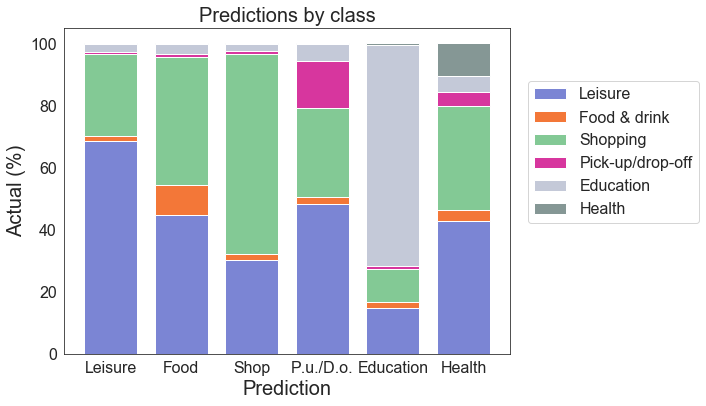

In [19]:
# plot the percentage
plot_stacked_bar_chart(percentage_prediction_by_class, ylabel='Actual (%)')

##### Interpretation
Similar interpretation to the confusion matrix, although here we can clearly see the dominance of Leisure & Shopping trip predictions in all classes other than Education.

## 2.3 Evaluation statistics
Statistics used to evaluate the model's performance

    2.3.1 F1 score, precision & recall
    2.3.2 Cohen's Kappa
    2.3.3 Mathews Correlation Coefficient (MCC)



### 2.3.1 F1 score, precision & recall
Visualise these scores

In [20]:
classification_report = sklearn.metrics.classification_report(TRUE_LABELS, PREDICTION_LABELS, output_dict=True)
classification_report_df = pd.DataFrame.from_dict(classification_report).T

In [21]:
classification_report_df

precision    recall  f1-score      support
0              0.528714  0.686382  0.597318  2012.000000
1              0.418750  0.098820  0.159905   678.000000
2              0.543621  0.642154  0.588794  1931.000000
3              0.472727  0.150725  0.228571   345.000000
4              0.724719  0.711397  0.717996   544.000000
5              0.600000  0.105727  0.179775   227.000000
accuracy       0.549242  0.549242  0.549242     0.549242
macro avg      0.548089  0.399201  0.412060  5737.000000
weighted avg   0.538775  0.549242  0.515502  5737.000000

In [22]:
precisions = classification_report_df['precision'][:6]
recalls = classification_report_df['recall'][:6]
f1_scores = classification_report_df['f1-score'][:6]

supports = classification_report_df['support'][:6]

key_values = [precisions, recalls, f1_scores]

In [23]:
def plot_classification_report(values, bar=False):
    """
        Plot values from the classification report
        :params values: (list of lists) scores from the classification for each class. Needs each list needs contain scores for each of the classes.
        :return ax: (matplotlib.pyplot.figure.axes) the axes of the figure so it can be saved as an image or edited
    """
    fig, ax = plt.subplots(1, figsize=(10,5))
    if not type(values) == list:
        values  = list(values)
        
    # plot either a bar or line
    if bar:
        # plot bar
        pd.DataFrame(values).T.plot.bar(ax=ax, color=COLOURBLIND_PALETTE)
    else:
        # plot line
        counter = 0
        for val in values:
            val.plot(ax=ax, color=COLOURBLIND_PALETTE[counter], marker=MARKER_TYPES[counter])
            counter += 1
    ax.legend(fontsize=16, loc=(1.04,0.4))
    plt.xlim(-0.2,5.2)
    ax.set_xticklabels(SHORT_NAMES, size=18)
    plt.yticks(size=16)
    plt.xlabel('Purpose',size=18)
    plt.ylabel('Score',size=18)
    plt.ylim(0,1)
    return ax
        

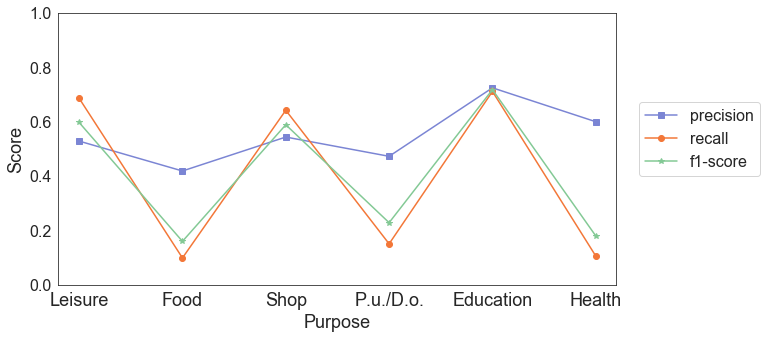

In [24]:
plot_classification_report(key_values)

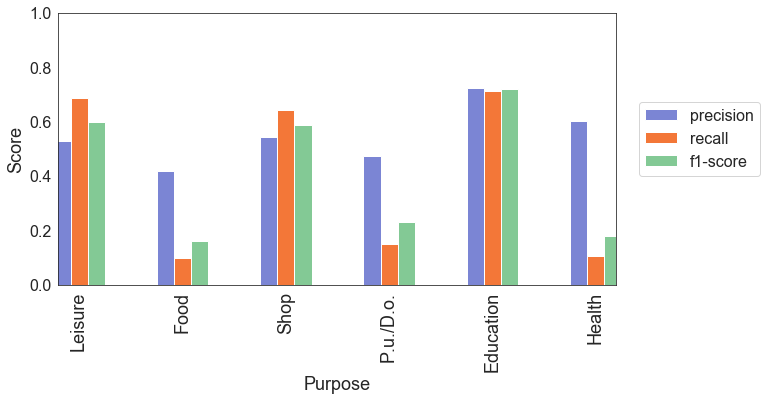

In [25]:
plot_classification_report(key_values, bar=True)

##### Interpretation
    o Relatively higher precision of Food, Pick-up and Health trips than recall. Especially for Health trips
 

### 2.3.2 Cohen's Kappa
Statistic comparing observed accuracy (i.e. our model predictions) vs expected accuracy (i.e. random chance)

Kappa = (observed accuracy - expected accuracy)/(1 - expected accuracy)

See: https://stats.stackexchange.com/questions/82162/cohens-kappa-in-plain-english

In [26]:
def calc_expected_accuracy(conf_matrix):
    """
        Make predictions based on a random classification
        
        expected_accuracy = (sum(( ground_truth_i * prediction_i ) /  total_values )) / total_values

        where: 
            _i = each class
            ground_truth == number of actual values of that class (sum of a row of the confusion matrix)
            prediction == number of prediction values of that class (sum of a columns of the confusion matrix)
            total_values == number of total values of any c;ass
        -------------------------
        :params conf_matrix: (list of lists) The confusion matrix calculated from sklearn
        :return expected_accuracy: (float) the expected accuracy from a random classification
    """
    # calculate the total amount of values
    total_values = conf_matrix.sum()
    num_rows = conf_matrix.shape[0]
    
    # calculate the total amount of values of each class
    ground_truths = [sum(row) for row in conf_matrix]

    # calculate the total amount of predictions of each class
    predictions = sum(conf_matrix)
    
    # carry out 
    expected_accuracy = 0
    for row in range(0, num_rows):
        expected_accuracy += (ground_truths[row] * predictions[row]) / total_values
    expected_accuracy = expected_accuracy / total_values
    return expected_accuracy

In [27]:
expected_accuracy = calc_expected_accuracy(conf_matrix)
print("Expected Accuracy", expected_accuracy)

Expected Accuracy 0.30704916320880554


In [28]:
print('Observed Accuracy', OBSERVERD_ACCURACY)

Observed Accuracy 0.5492417639881472


In [29]:
# useful when comparing predictions to random set of predictions 
kappa_statistic = (OBSERVERD_ACCURACY - expected_accuracy) / (1 - expected_accuracy)
print("Kappa Statistic =", kappa_statistic)

Kappa Statistic = 0.3495090674842796


In [30]:
## LATE REVISION: SAME AS ->
sklearn.metrics.cohen_kappa_score(TRUE_LABELS, PREDICTION_LABELS)

0.34950906748427946

##### Interpretation
This is Kappa score is considered low indicating our prediction is only a little bit better than using the ground truth. NOTE: roughly values between 0.41–0.6 are considered moderate, 0.61–0.8 substatial and 0.81+ excellent.

Paper on probelms with Cohen’s Kappa: 
https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0222916 

### 2.3.3 Mathews Correlation Coefficient (MCC)

##### Interpretation

# 3. Spatial analysis of errors
We trying to discern if there are particular areas in the city where our model was less accurate for a given purpose class

3.1. General mapping  
3.2. Kernel density estimation (KDE)  
3.3. Spatial tests     

## 3.1. General mapping
Mapping of correcly and incorrectly  classified trips including by purpose

In [31]:
def plot_mtl_points(data, plot_title, ax=None, legend=True):
    """
        Plot points across the area of Montreal. Projection == Canada Lambert (epsg:3347)
        -----------------------------
        :params data: (geopandas.GeoDataFrame) Data containing Point objects as geometry
        :params plot_title: (string) Title for map
        :params ax: (matplotlib.axes._subplots.AxesSubplot) the axes of the figure for subplotting
        :params legend: (boolean) whether a legend should be plotted
        :return ax: (matplotlib.axes._subplots.AxesSubplot) the axes of the figure so it can be saved as an image or edited
    """
    if not ax:
        fig, ax  = plt.subplots(1)
    mtl_dissem.plot(ax=ax, color='lightgrey', linewidth=.1)
    data.plot(ax=ax, markersize=.8)
    ax.set_xlim(MIN_LON, MAX_LON)
    ax.set_ylim(MIN_LAT, MAX_LAT)
    if legend:
        ax.legend(['Trip end points'], fontsize=14, loc=(1.04,0.8))
    ax.set_title(plot_title, size=16)
    ax.set_xticklabels('');
    ax.set_yticklabels('');
    return ax

In [32]:
correct_trips = predictions_17_gdf.loc[predictions_17_gdf['correct'] == True]
incorrect_trips = predictions_17_gdf.loc[predictions_17_gdf['correct'] == False]
in_the_city = gpd.sjoin(city_of_montreal, predictions_17_gdf, how='left', op='intersects')
outside_the_city = predictions_17_gdf.loc[~predictions_17_gdf['id_trip'].isin(in_the_city['id_trip'].unique())]

/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/geopandas/tools/sjoin.py:56: UserWarning: CRS of frames being joined does not match!({'init': 'epsg:3347'} != EPSG:3347)
  '(%s != %s)' % (left_df.crs, right_df.crs))


In [33]:
## look at how many correct/incorrect trips there are within and outside the City of Montreal
print('Trips in the city')
print(in_the_city['correct'].value_counts(), '\n')
print('Trips outside the city')
print(outside_the_city['correct'].value_counts())

Trips in the city
True     2666
False    2192
Name: correct, dtype: int64 

Trips outside the city
True     485
False    394
Name: correct, dtype: int64


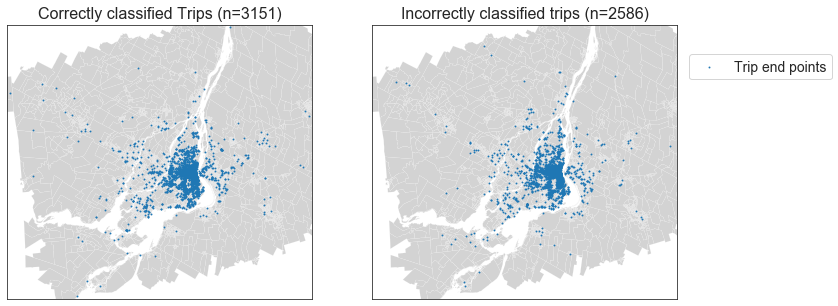

In [34]:
fig, axes = plt.subplots(1,2, figsize=(12,8))
plot_mtl_points(correct_trips, plot_title='Correctly classified Trips (n=%s)' % (len(correct_trips)),\
                ax=axes[0], legend=False)
plot_mtl_points(incorrect_trips, plot_title='Incorrectly classified trips (n=%s)'% (len(incorrect_trips)),\
                ax=axes[1])

##### Interpretation
    o Extreme spatial un-eveness of trip end points
    o Correctly and Incorrectly classified trips are relatively indistinguishable in this visualisation. We need to investigate individual purpose types


Compare true vs false for each purpose type

In [35]:
def plot_mtl_points_truevsfalse(data, plot_title, ax=None, legend=False):
    """
        Plot points across the area of Montreal True vs False. Projection == Canada Lambert (epsg:3347)
        --------------------------
        :params data: (geopandas.GeoDataFrame) Data containing Point objects as geometry
        :params plot_title: (string) Title for map
        :params ax: (matplotlib.axes._subplots.AxesSubplot) the axes of the figure for subplotting
        :params legend: (boolean) whether a legend should be plotted
        :return ax: (matplotlib.pyplot.figure.axes) the axes of the figure so it can be saved as an image or edited
    """
    if not ax:
        fig, ax = plt.subplots(1)
    mtl_dissem.plot(ax=ax, color='lightgrey', linewidth=.1)
    data.plot('correct', cmap='bwr',categorical=True, legend=legend, s=3, ax=ax, legend_kwds={'loc':(1.04,0.5),\
                                                                                         'fontsize':14})
    ax.set_xlim(MIN_LON, MAX_LON)
    ax.set_ylim(MIN_LAT, MAX_LAT)
    ax.set_title(plot_title, size=14)
    ax.set_xticklabels('');
    ax.set_yticklabels('');
    return ax

In [36]:
def true_false_title(pur, data):
    """
       Returns a title with true and false values for that purpose
       -------------------
       :params pur: (int) purpose number
       :params data: (DataFrame) data containing predictions of each purpose
       :return title: (str) a title to be used in a plot
    """
    title = 'Prediction: ' + LONG_NAMES[pur] + ' (T=%s F=%s)' % (data['correct'].value_counts()[True], data['correct'].value_counts()[False]) # SAFER ALTERNATIVE  purpose_name = PURPOSE_CLASSES[pur].capitalize() + ' trips'
    return title 


def basic_title_func(pur, data):
    return LONG_NAMES[pur]


def subplot_of_each_purpose(data, num_columns, num_rows, plot_func, title_func, suptitle='', legend=False):
    """
        Plots a map for each purpose. Takes a plot function (plot_func) and title function (title_func)
        and uses these to build the subplot of each purpose type
        -----------------
        :params data: (DataFrame) predictions data
        :params num_columns: (int) Number of subplots to a columns
        :params num_rows: (int) Number of subplots to a row
        :params plot_func: (function) Function for creating a subplot visualisation
        :params title_func: (function) Function for creating a plot title for each subplots 
        :params suptitle: (str) Super-title for the plot
        :params legend: (boolean) whether the plot function contains legend argument 
        :return fig: (matplotlib.pyplot.figure) For saving the figure
    """
    
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(20,12))
    row_ind = -1 # start at -1 so it can be incremented once before first plot
    for pur in sorted(data['prediction'].unique()):
        pur_data = data.loc[data.prediction == pur]
        plot_title = title_func(pur, pur_data)
        if pur % num_columns == 0:
            # increment the row index if the row is full
            row_ind += 1
        col_ind = pur % num_columns
        if legend and col_ind == num_columns - 1:
            plot_func(pur_data, plot_title=plot_title, ax=axes[row_ind][col_ind], legend=True)
        else:
            plot_func(pur_data, plot_title=plot_title, ax=axes[row_ind][col_ind])
    plt.suptitle(suptitle, size=26)
    return fig

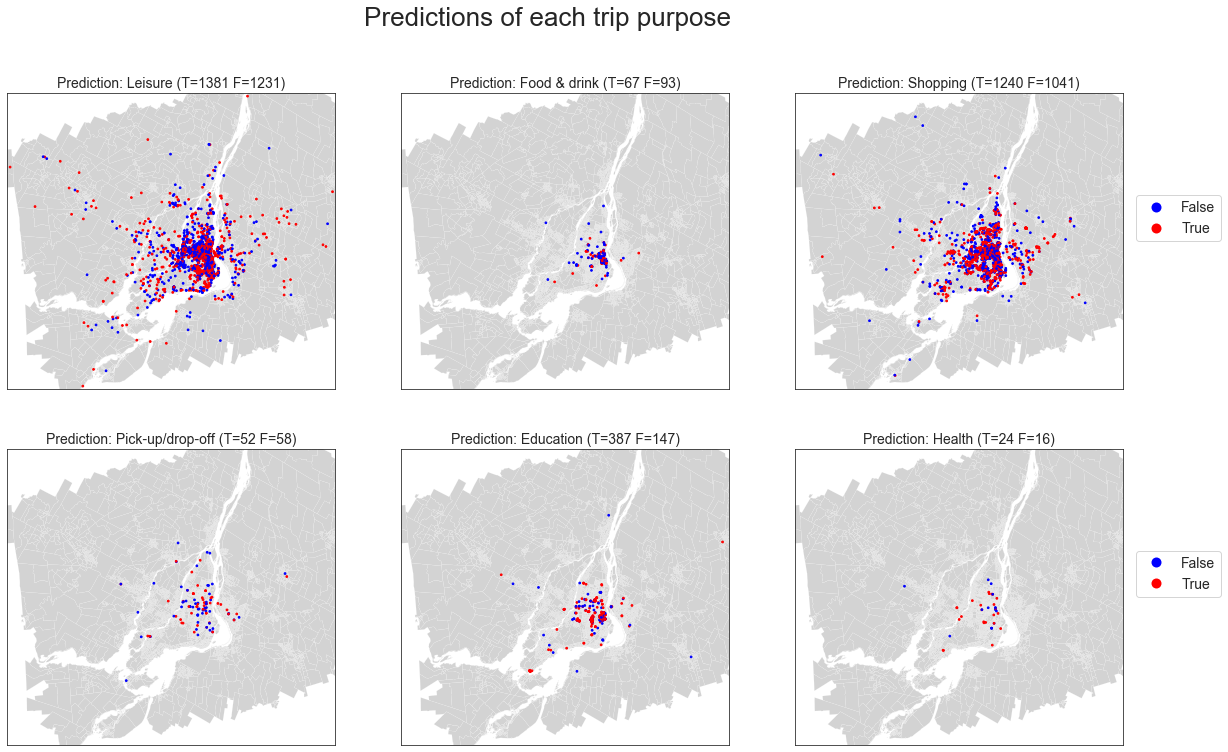

In [37]:
fig = subplot_of_each_purpose(data=predictions_17_gdf, num_columns=3, num_rows=2,\
                        plot_func=plot_mtl_points_truevsfalse, title_func=true_false_title,\
                        suptitle='Predictions of each trip purpose', legend=True)

##### Interpretation
It is difficult to interpret these maps visually as there are still 100 to 1000s of trips on some of these maps. 

###### Basic Intrepretation
    o Roughly, and as expected (from the underlying distribution of trip end points), more correctly classified trips are found in the area of Downtown Montreal across all purpose types
    o Where predictions of trips of the same purpose are not near other trips that are predicted to be that purpose (i.e. typically at the further extent of the study area) they are relatively inaccurate (except for leisure & shopping)

Actual values in and outside the city

In [38]:
## look at how many correct/incorrect trips there are within and outside the City of Montreal
print('-'*50)
for pur in sorted(predictions_17_gdf['prediction'].unique()):
    print(LONG_NAMES[pur] + ':')
    print('Trips in the city:')
    print(in_the_city.loc[in_the_city.prediction == pur]['correct'].value_counts().sort_index(ascending=False), '\n')
    print('Trips outside the city:')
    print(outside_the_city.loc[outside_the_city.prediction == pur]['correct'].value_counts().sort_index(ascending=False))
    print('-'*50)

--------------------------------------------------
Leisure:
Trips in the city:
True     1140
False    1013
Name: correct, dtype: int64 

Trips outside the city:
True     241
False    218
Name: correct, dtype: int64
--------------------------------------------------
Food & drink:
Trips in the city:
True     64
False    90
Name: correct, dtype: int64 

Trips outside the city:
True     3
False    3
Name: correct, dtype: int64
--------------------------------------------------
Shopping:
Trips in the city:
True     1045
False     896
Name: correct, dtype: int64 

Trips outside the city:
True     195
False    145
Name: correct, dtype: int64
--------------------------------------------------
Pick-up/drop-off:
Trips in the city:
True     40
False    46
Name: correct, dtype: int64 

Trips outside the city:
True     12
False    12
Name: correct, dtype: int64
--------------------------------------------------
Education:
Trips in the city:
True     358
False    134
Name: correct, dtype: int64 

Tr

##### Interpretation
see percentage interpretation

Percentage

In [39]:
## look at the proportion of correct/incorrect trips there are within and outside the City of Montreal
print('-'*50)
for pur in sorted(predictions_17_gdf['prediction'].unique()):
    print(LONG_NAMES[pur] + ':')
    print('Trips in the city:')
    print((in_the_city.loc[in_the_city.prediction == pur]['correct'].value_counts().sort_index(ascending=False) / len(in_the_city.loc[in_the_city.prediction == pur]))*100, '\n')
    print('Trips outside the city:')
    print((outside_the_city.loc[outside_the_city.prediction == pur]['correct'].value_counts().sort_index(ascending=False) / len(outside_the_city.loc[outside_the_city.prediction == pur]))*100)
    print('-'*50)

--------------------------------------------------
Leisure:
Trips in the city:
True     52.949373
False    47.050627
Name: correct, dtype: float64 

Trips outside the city:
True     52.505447
False    47.494553
Name: correct, dtype: float64
--------------------------------------------------
Food & drink:
Trips in the city:
True     41.558442
False    58.441558
Name: correct, dtype: float64 

Trips outside the city:
True     50.0
False    50.0
Name: correct, dtype: float64
--------------------------------------------------
Shopping:
Trips in the city:
True     53.838228
False    46.161772
Name: correct, dtype: float64 

Trips outside the city:
True     57.352941
False    42.647059
Name: correct, dtype: float64
--------------------------------------------------
Pick-up/drop-off:
Trips in the city:
True     46.511628
False    53.488372
Name: correct, dtype: float64 

Trips outside the city:
True     50.0
False    50.0
Name: correct, dtype: float64
-----------------------------------------

##### Interpretation
    o Food and Drink trips are incorrectly classified inside the City more times (42%) than they are correctly classified (58%)
    o Education has the highest percentage of correctly classified trips in the City (73%)
    o Highest percentage of trips correctly classified outside the City are Education (69%), Health (63%) and Shopping (57%)

## Kernel Density Estimation (KDE)
TODO: 
    - determine the kernel & band-width

In [40]:
def plot_mtl_kde(data, plot_title, ax=None):
    """
        Plot KDE across the area of Montreal. Projection == Canada Lambert (epsg:3347)
        --------------------------
        :params data: (geopandas.GeoDataFrame) Data containing Point objects as geometry
        :params plot_title: (string) Title for map
        :params ax: (matplotlib.axes._subplots.AxesSubplot) the axes of the figure for subplotting
        :return ax: (matplotlib.pyplot.figure.axes) the axes of the figure so it can be saved as an image or edited
    """
    if not ax:
        fig, ax = plt.subplots(1)
    mtl_dissem.plot(ax=ax, color='lightgrey', linewidth=.1)
    sns.kdeplot(data.endx, data.endy, s=.5, cmap='viridis', ax=ax)
    ax.set_xlim(MIN_LON, MAX_LON)
    ax.set_ylim(MIN_LAT, MAX_LAT)
    ax.set_xticklabels([]);
    ax.set_yticklabels([]);
    ax.set_xlabel("");
    ax.set_ylabel("");
    ax.set_title(plot_title, size=20)
    return ax

/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/seaborn/distributions.py:423: UserWarning: The following kwargs were not used by contour: 's'
  cset = contour_func(xx, yy, z, n_levels, **kwargs)


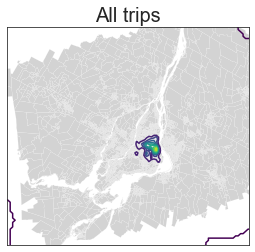

In [41]:
plot_mtl_kde(predictions_17, 'All trips')

KDE of correctly and incorrectly predicted trips

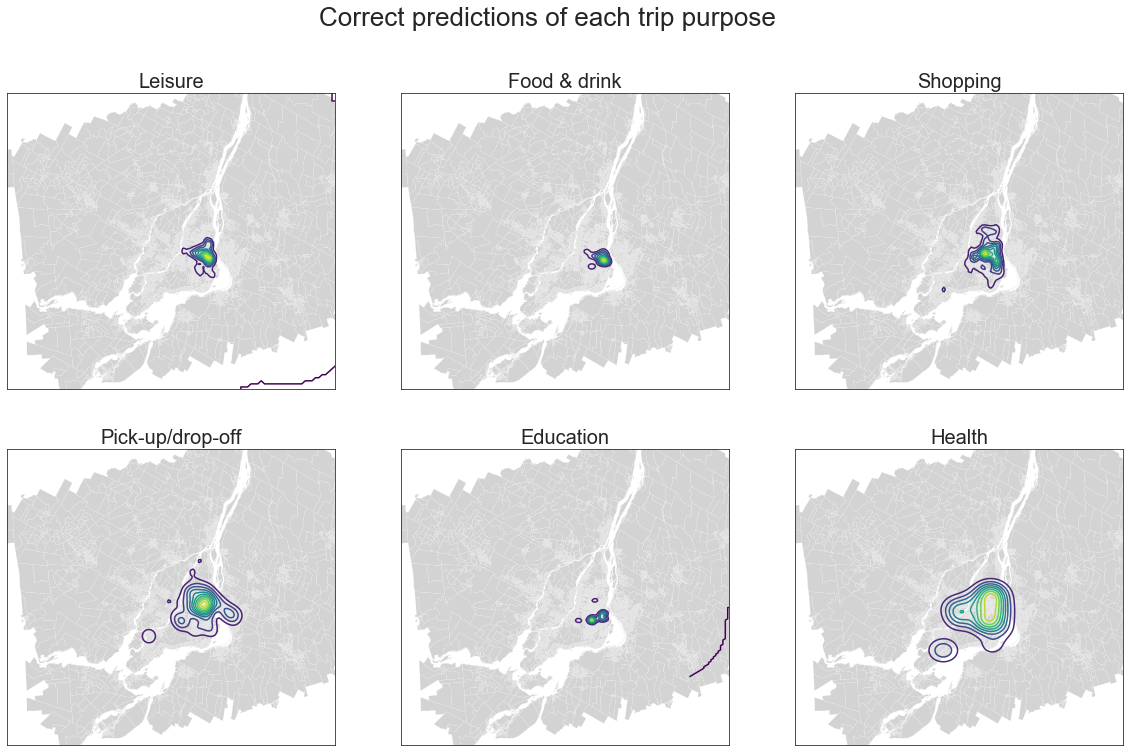

In [42]:
fig = subplot_of_each_purpose(data=correct_trips, num_columns=3, num_rows=2,\
                        plot_func=plot_mtl_kde, title_func=basic_title_func,\
                        suptitle='Correct predictions of each trip purpose', legend=False)

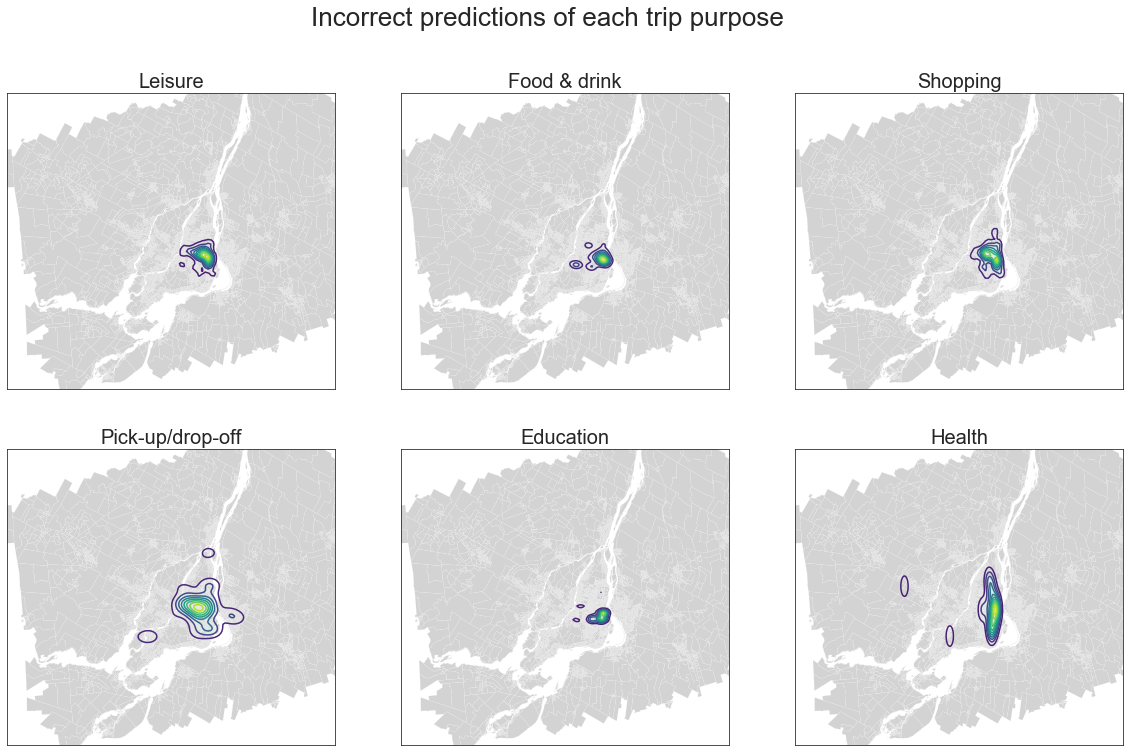

In [43]:
fig = subplot_of_each_purpose(data=incorrect_trips, num_columns=3, num_rows=2,\
                        plot_func=plot_mtl_kde, title_func=basic_title_func,\
                        suptitle='Incorrect predictions of each trip purpose', legend=False)

KDE of incorrectly predicted trips

##### Intrepretation
    o Education is highly concentrated around Downtown Montreal
    o Health & Pu/Do highest kernel range 

Within and outside the city KDE (overall)

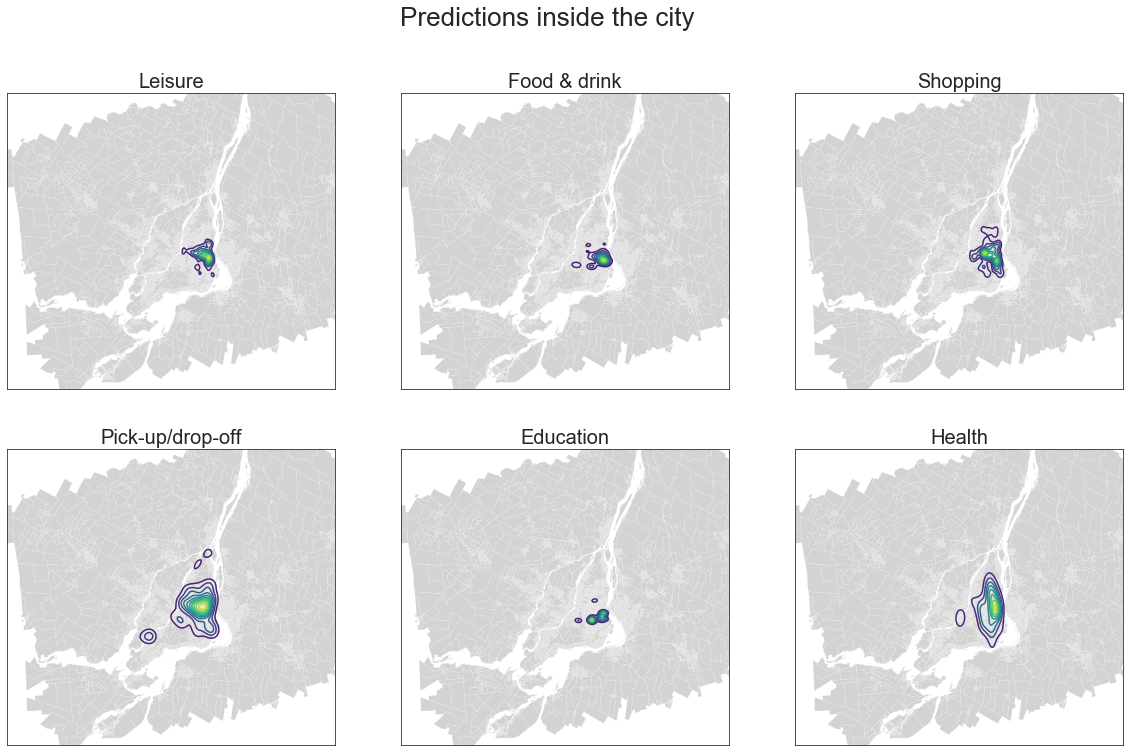

In [44]:
fig = subplot_of_each_purpose(data=in_the_city, num_columns=3, num_rows=2,\
                        plot_func=plot_mtl_kde, title_func=basic_title_func,\
                        suptitle='Predictions inside the city', legend=False)

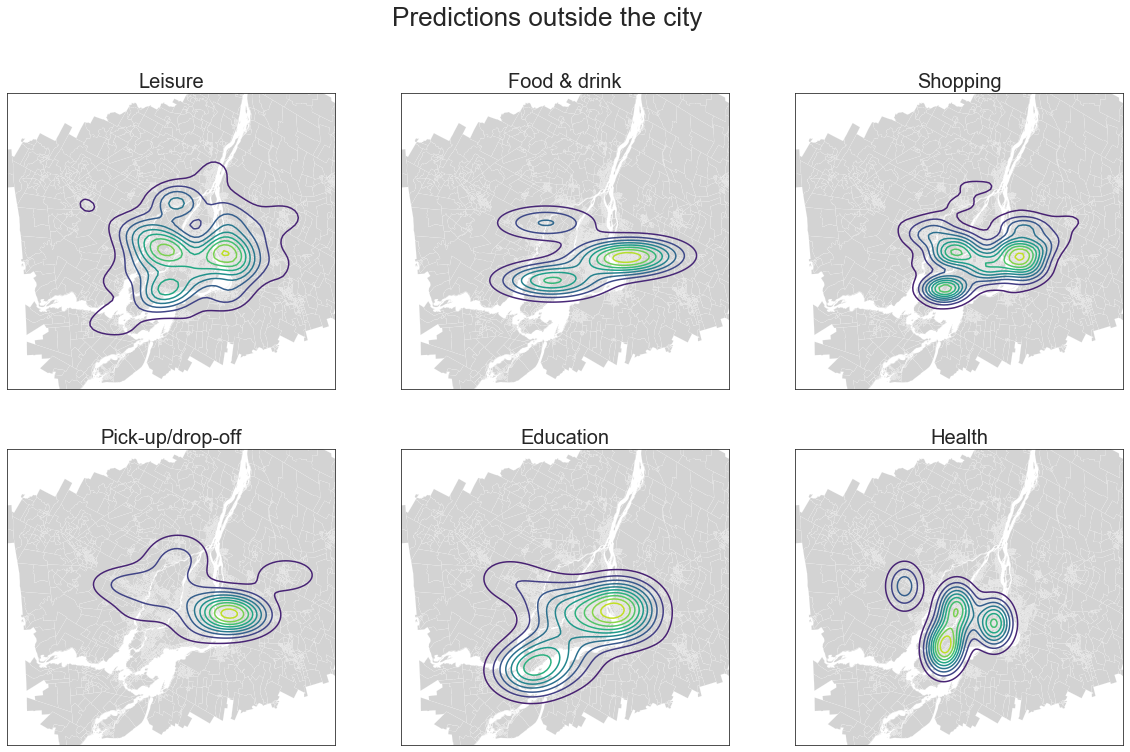

In [45]:
fig = subplot_of_each_purpose(data=outside_the_city, num_columns=3, num_rows=2,\
                        plot_func=plot_mtl_kde, title_func=basic_title_func,\
                        suptitle='Predictions outside the city', legend=False)

##### Intrepretation
    o Majority trips are towards the south of Montreal Island and across the river from downtown
    o Pick-up/drop-off has one main cluster

## 3.3 Spatial Statistics
    3.3.0 Instantiate point pattern data
    3.3.1 Spatial auto-correlation   
    3.3.2 Spatial dependency   
    3.3.3 Spatial centrography

### 3.3.0  Instantiate point pattern data

In [46]:
# create point
X_Y_WGS = predictions_17_gdf.to_crs({'init':'epsg:4236'}).apply(lambda row: [row.end_point.x,row.end_point.y,\
                                                                             row.prediction],axis=1).to_list()

In [47]:
X_Y_WGS[:5]

[[-73.545318, 45.55066099999993, 2],
 [-73.558836, 45.55091699999993, 2],
 [-73.201936, 45.53707199999993, 2],
 [-73.58566000000002, 45.55577799999993, 0],
 [-73.752034, 45.56664899999994, 2]]

In [48]:
pp = pointpats.PointPattern(X_Y_WGS)

In [49]:
pp.points.head()

x          y
0 -73.545318  45.550661
1 -73.558836  45.550917
2 -73.201936  45.537072
3 -73.585660  45.555778
4 -73.752034  45.566649

### 3.3.1 Spatial centrography
Measures of spatial centering

In [50]:
from pointpats.centrography import hull, mbr, mean_center, weighted_mean_center, manhattan_median, std_distance,euclidean_median,ellipse
from matplotlib.patches import Ellipse
from pylab import figure, show,rand

In [51]:
mc = mean_center(pp.points)
mc

array([-73.60112261,  45.52738663])

In [52]:
stdd = std_distance(pp.points)
stdd

0.10969244996952222

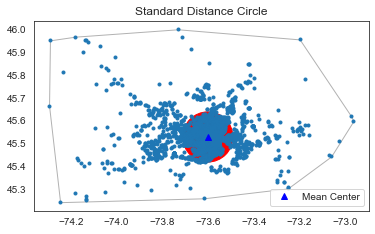

In [53]:
circle1=plt.Circle((mc[0], mc[1]),stdd,color='r')
ax = pp.plot(get_ax=True, title='Standard Distance Circle', hull=True)
plt.plot(mc[0], mc[1], 'b^', label='Mean Center')
ax.add_artist(circle1)
ax.set_aspect('equal')
plt.legend(numpoints=1)

In [54]:
sx, sy, theta = ellipse(pp.points)
sx, sy, theta

(0.07921404898552185, 0.1333922086045507, -1.5604719799344673)

In [55]:
theta_degree = np.degrees(theta) #need degree of rotation to plot the ellipse
theta_degree


-89.40845849866827

<Figure size 432x288 with 0 Axes>

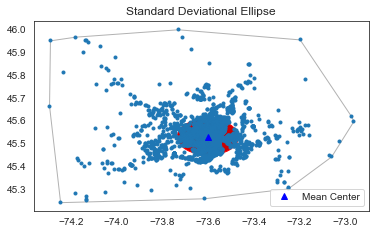

In [56]:
fig = plt.figure()
e = Ellipse(xy=mean_center(pp.points), width=sx*2, height=sy*2, angle=-theta_degree) #angle is rotation in degrees (anti-clockwise)
ax = pp.plot(get_ax=True, title='Standard Deviational Ellipse', hull=True)
ax.add_artist(e)
e.set_clip_box(ax.bbox)
e.set_facecolor([0.8,0,0])
e.set_edgecolor([1,0,0])
ax.set_aspect('equal')
plt.plot(mc[0], mc[1], 'b^', label='Mean Center')
plt.legend(numpoints=1)
show()

Distance Statistics

In [57]:
pp.max_nnd

0.1739786810071806

### 3.3.2 Spatial dependency & auto-correlation
Description:

In [58]:
def aggregate_data_into_dissemination_areas(data, dissemination_areas, grouped_column):
    """
        Aggregates prediction data (Point data) into the Montreal Dissemination areas.
        First it spatially joins the two based on trips (Points) which are found within a given areas (Polygons).
        Both data projections must be the same (i.e. EPSG:3347)
        ------------------------
        :params data: (Geopandas.GeoDataFrame) Main prediction data
        :params dissemination_areas: (Geopandas.GeoDataFrame) Data containing Polygon geometry columns
        :params grouped_column: (string) Column to include in aggregation 
        :return aggregated_data: (Geopandas.GeoDataFrame) Data containing the aggregated predictions into each dissemination area
    """
    aggregated_data = gpd.sjoin(data, dissemination_areas, op='within')
    
    # check for duplicates
    assert len(aggregated_data) == aggregated_data['id_trip'].nunique()
    
    # groupby data by count of each purpose type in each unique Dissemination area ID (DAUID) and whether the prediction was correct or not
    aggregated_data = aggregated_data.groupby(['correct',grouped_column,'DAUID']).size()
    # rotate data so index becomes columns (so columns are: (True/False and purpose class))
    aggregated_data = aggregated_data.unstack().T.reset_index()
    
    # merge data back to original data so we can extract the geometry (Polygons)
    aggregated_data = aggregated_data.merge(dissemination_areas[['DAUID','geometry']], on='DAUID', how='outer')
    
    # replace NaN values (where no trip is recorded in )
    aggregated_data = aggregated_data.fillna(0.0)
    
    # drop and rename columns 
    aggregated_data = aggregated_data.drop(aggregated_data.columns[1],axis=1) # drops duplicate DAUID column
    aggregated_data.columns = [replace_parenthesis(col_name) for col_name in aggregated_data.columns]
    
    # turn back into GeoDataFrame object for plotting
    aggregated_data = gpd.GeoDataFrame(aggregated_data)
    
    return aggregated_data


def replace_parenthesis(some_text):
    """
        Simple function for removing unwanted parentheses and commas from a string
        ------------------------
        :params some_text: (string) some text
        :return formatted_text: (string) formatted text with no parentheses and commas
    """
    
    some_text = str(some_text)
    formatted_text = some_text.replace('(','').replace(')','').replace(',','').replace(' ','')
    return formatted_text

In [59]:
prediction_aggregated_data = aggregate_data_into_dissemination_areas(predictions_17_gdf, mtl_dissem, 'prediction')
purpose_aggregated_data = aggregate_data_into_dissemination_areas(predictions_17_gdf, mtl_dissem, 'purpose')

/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/geopandas/tools/sjoin.py:56: UserWarning: CRS of frames being joined does not match!(EPSG:3347 != {'init': 'epsg:3347'})
  '(%s != %s)' % (left_df.crs, right_df.crs))
/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/pandas/core/reshape/merge.py:618: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


In [60]:
len(prediction_aggregated_data)

7046

In [61]:
prediction_aggregated_data.tail()

DAUID  False0  False1  False2  False3  False4  False5  True0  True1  \
7041  24660887     0.0     0.0     0.0     0.0     0.0     0.0    0.0    0.0   
7042  24650141     0.0     0.0     0.0     0.0     0.0     0.0    0.0    0.0   
7043  24661823     0.0     0.0     0.0     0.0     0.0     0.0    0.0    0.0   
7044  24670143     0.0     0.0     0.0     0.0     0.0     0.0    0.0    0.0   
7045  24640247     0.0     0.0     0.0     0.0     0.0     0.0    0.0    0.0   

      True2  True3  True4  True5  \
7041    0.0    0.0    0.0    0.0   
7042    0.0    0.0    0.0    0.0   
7043    0.0    0.0    0.0    0.0   
7044    0.0    0.0    0.0    0.0   
7045    0.0    0.0    0.0    0.0   

                                               geometry  
7041  (POLYGON ((7629302.705682553 1236296.537157104...  
7042  (POLYGON ((7619469.471425552 1247941.425697241...  
7043  (POLYGON ((7629522.740002374 1247945.368623123...  
7044  (POLYGON ((7621117.377171299 1226897.425738305...  
7045  (POLYGON ((7620465.720018841 1265280.120023799...

In [62]:
# build Queen's case spatial weight matrix
wq = ps.lib.weights.contiguity.Queen.from_dataframe(mtl_dissem)

/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/pysal/lib/weights/weights.py:168: UserWarning: There are 4 disconnected observations 
  Island ids: 3641, 4879, 6388, 6599
  " Island ids: %s" % ', '.join(str(island) for island in self.islands))


('WARNING: ', 3641, ' is an island (no neighbors)')
('WARNING: ', 4879, ' is an island (no neighbors)')
('WARNING: ', 6388, ' is an island (no neighbors)')
('WARNING: ', 6599, ' is an island (no neighbors)')
Moran's I: -0.0022140376006491804 P-value (simulated): 0.407


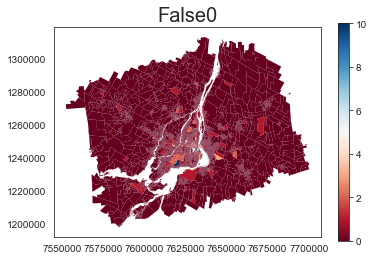

Moran's I: 0.001120323573085746 P-value (simulated): 0.295


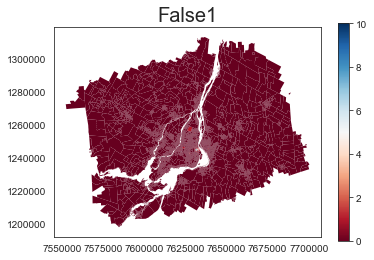

Moran's I: -0.003332212924756689 P-value (simulated): 0.313


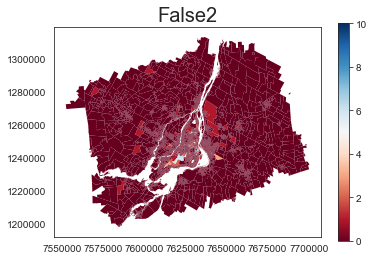

Moran's I: -0.0074687681391255294 P-value (simulated): 0.012


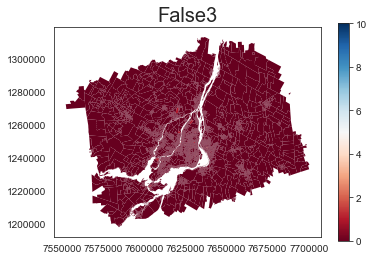

Moran's I: 0.0017898601811526464 P-value (simulated): 0.238


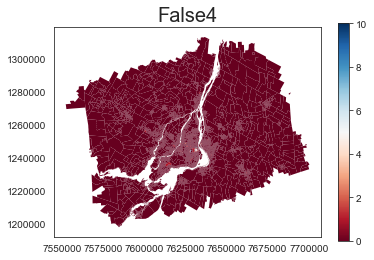

Moran's I: -0.001560812369001651 P-value (simulated): 0.162


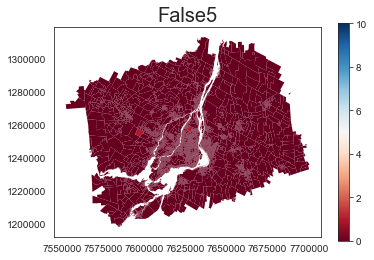

Moran's I: 0.0008154546542346791 P-value (simulated): 0.405


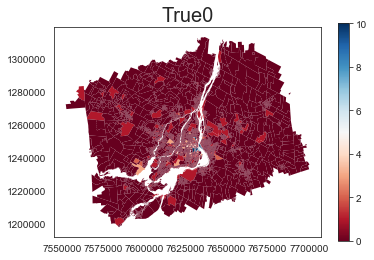

Moran's I: -0.0017745306802142572 P-value (simulated): 0.433


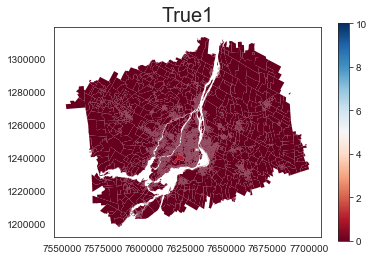

Moran's I: -0.003355289701407547 P-value (simulated): 0.312


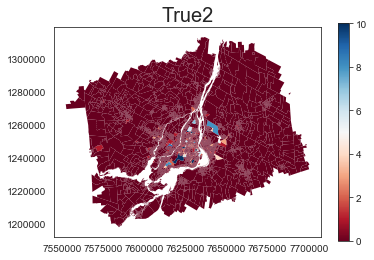

Moran's I: 0.010433679176309007 P-value (simulated): 0.077


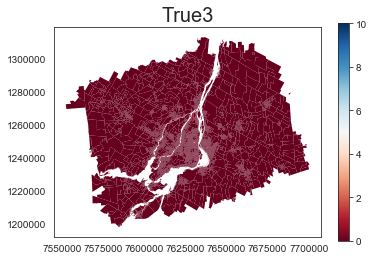

Moran's I: -0.0009215960657430854 P-value (simulated): 0.338


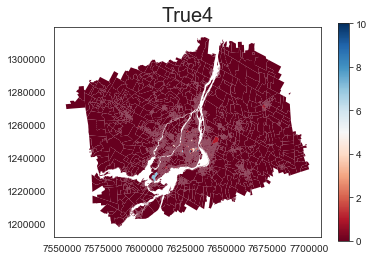

Moran's I: -0.0030558788879863578 P-value (simulated): 0.476


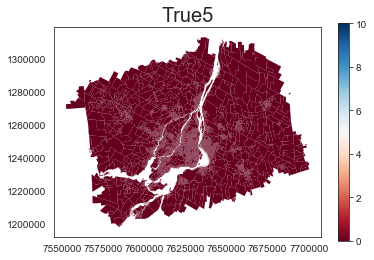

CPU times: user 36.3 s, sys: 923 ms, total: 37.2 s
Wall time: 36.4 s


In [63]:
%%time
VMAX = 10

for col in prediction_aggregated_data.columns[1:-1]:
    # calculate local Moran's I
    y = prediction_aggregated_data[col].values
    moran_global = ps.explore.esda.Moran(y, wq)
    print("Moran's I:", moran_global.I, "P-value (simulated):", moran_global.p_sim)
    
    prediction_aggregated_data.plot(col,cmap='RdBu', legend=True, linewidth=0, vmax=VMAX)
    plt.title(col, size=20)
    plt.show()

In [64]:
from splot.esda import plot_local_autocorrelation, lisa_cluster

In [65]:
def lisa_plot(data, column, weight_matrix, dissemination_areas):
    """
       Calculate Local Moran's I (a test for spatial auto-correlation within each dissemenation area)
       then map the values of I in a Local Indicator of Spatial Association (LISA) plot.
       HH == High-High (High values of Moran's I surrounded by High values)
       HL == High-Low (High values of Moran's I surrounded by Low values)
       LH == Low-High (...)
       LL == Low-Low (...)
       ns == not significant
    """
    # build spatial weight matrix and calculate Global and Local Moran's I
    y = data[column].values
    moran_loc = ps.explore.esda.Moran_Local(y, weight_matrix)
    fig, ax = plt.subplots(1)
    splot.esda.lisa_cluster(moran_loc, dissemination_areas, ax=ax, legend_kwds={'title':'LISA', 'fontsize':12})
    ax.set_title("LISA map "+col, size=22)
#     print(moran_loc.Is)
#     print(moran_loc.p_sim)
    return ax

/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/pysal/explore/esda/moran.py:895: RuntimeWarning: invalid value encountered in true_divide
  self.z_sim = (self.Is - self.EI_sim) / self.seI_sim
/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1807: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= _b) & cond0


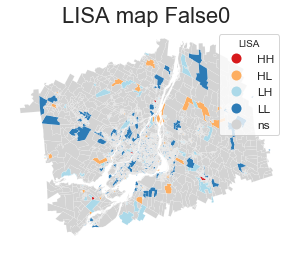

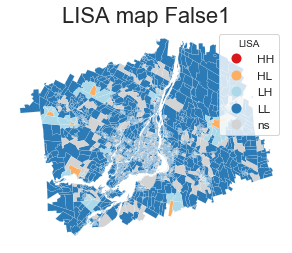

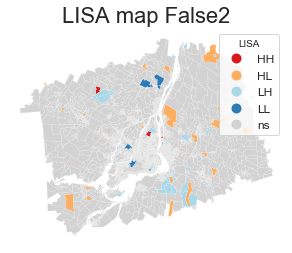

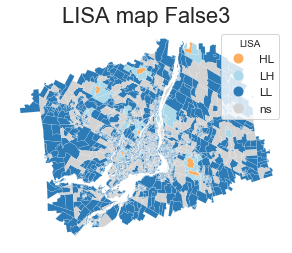

In [ ]:
%%time
for col in prediction_aggregated_data.columns[1:-1]:
    lisa_plot(prediction_aggregated_data, col, wq, mtl_dissem)
    plt.show()

# 4. Temporal analysis
We trying to discern if there are particular times of day, days of week or weeks of month where our model was less accurate for a given purpose class
    
    4.0. Underlying temporal distribution of trips
    4.1. Time-series of errors  
    4.2. Calendar plot of errors   
    4.3. Temporal decomposition  
    4.4. Augmented Dickey-Fuller (ADF) test  


## 4.0 Underlying temporal distribution of trips
look at the underlying distribution of trips within the prediction data

In [ ]:
count_of_prediction_each_day = predictions_17.set_index('endtime').groupby([pd.Grouper(freq='1d')]).size()

In [ ]:
count_of_prediction_each_day.plot(marker='s', markersize=4)
plt.title('Count of trips each day', size=16)
plt.xlabel('Date', size=14)
plt.ylabel('Count', size=14)

##### Interpretation
    o The most amount of trips are found between 29th – 30th September, 5th – 7th October
    

## 4.1 Time-series of errors

    4.1.1 by day
    4.1.2 by hour

In [ ]:
def group_time_data_by_purpose(time_data, frequency, purposes):
    """
        Subset data into purpose then group the data into a given frequency of time
        ---------------
        :params time_data: (pandas.DataFrame) Data with a datetime index
        :params frequency: (string) the frequency of time that the data will be grouped by
        :params purposes: (string or list) Purpose classes to subset the data by
        :return grouped_data: (pandas.DataFrame) data 
    """
    if not type(purposes) == list:
        purposes = [purposes]
    # subset data
    time_data = time_data.loc[time_data.purpose.isin(purposes)]
    # group data by time frequency
    grouped_data = time_data.groupby(pd.Grouper(freq=frequency)).agg({'correct':'mean'})
    return grouped_data

### 4.1.1. by day

In [ ]:
# Create a dataframe containing the correct prediction made per unique timestamp
correct_predictions_per_timestamp = predictions_17.set_index(['endtime'])[['correct','purpose','prediction']]

In [ ]:
correct_predictions_per_timestamp.head()

In [ ]:
# use the function defined above to calculate the proportion of correct trips of each class per day
frequency = '1d' # One day
correct_predictions_by_day = group_time_data_by_purpose(correct_predictions_per_timestamp,
                                                        frequency=frequency, purposes=[0,1,2,3,4,5])

In [ ]:
correct_predictions_by_day.plot(marker='s')
plt.title('Accuracy of model by day', size=16)
plt.ylim(0,1)
plt.show()

In [ ]:
fig, ax  = plt.subplots(1, figsize=(8,6))
for pur in sorted(correct_predictions_per_timestamp['purpose'].unique()):
    pur_df = group_time_data_by_purpose(correct_predictions_per_timestamp, '1d', [pur])
    pur_df.plot(marker='s', markersize=3, ax=ax)
plt.title('Average prediction accuracy', size=16)
plt.legend(PURPOSE_CLASSES.values(), loc=(1.04,0.5))

### 4.1.2 by hour

In [ ]:
def average_accuracy_by_hour(data, plot_title, frequency = '1h', purposes=[0,1,2,3,4,5]):
    fig, ax = plt.subplots(1, figsize=(10,6))
    
    # Create a dataframe containing the correct prediction made per unique timestamp
    correct_predictions_per_timestamp = data.set_index(['endtime'])[['correct','purpose','prediction']]
    
    # use the function defined above to calculate the proportion of correct trips of each class per day
    correct_predictions_by_hour = group_time_data_by_purpose(correct_predictions_per_timestamp,
                                                        frequency=frequency, purposes=purposes)
    
    # create an hour column to perform groupby on
    correct_predictions_by_hour['hour'] = correct_predictions_by_hour.index.hour
    
    # perform groupby
    grouped_predictions_by_hour = correct_predictions_by_hour.groupby(['hour']).agg({'correct':'mean'}) * 100
    
    # plot data
    grouped_predictions_by_hour.plot.bar(ax=ax, legend=False)
    grouped_predictions_by_hour.plot(ax=ax, legend=False, marker='s', color='k', alpha=.75)
    ax.set_ylabel('Average Accuracy (%)', size=20)
    ax.set_xlabel('Hour of day', size=20)
    ax.set_ylim(0,100)
    ax.set_xlim(-0.5,23.5)    
    ax.set_title(plot_title, size=24)
    plt.yticks(size=16)
    plt.xticks(size=16, rotation=0)
    return ax

In [ ]:
ax = average_accuracy_by_hour(predictions_17_gdf, plot_title='Model accuracy by hour')


In [ ]:
for pur in sorted(predictions_17_gdf['purpose'].unique()):
    plot_title = '%s: Model accuracy by hour' % (PURPOSE_CLASSES[pur].capitalize())
    ax = average_accuracy_by_hour(predictions_17_gdf, plot_title=plot_title, purposes=[pur])
    plt.show()

##### Interpretation:
    o 
    o 

## 4.2 Calendar plot

In [ ]:
def create_data_calendar(data, agg={'id_trip':'count'}):
    data = data.set_index('endtime').groupby([pd.Grouper(freq='1h')]).agg(agg)
    
    min_date = data.index.min().strftime('%Y–%m-%d')
    max_date = data.index.max() - datetime.timedelta(days=1)
    max_date = max_date.strftime('%Y–%m-%d')
    first_col = data.columns[0]
    data_per_hour = pd.concat([data[data.index.hour == x].reset_index()[first_col] for x in range(0,24)], axis=1).T
    data_per_hour.index = np.arange(0,24)

    data_per_hour.columns = [str(dt.date()) for dt in pd.date_range('2017-09-18', '2017-10-17', freq='D')]
    
    return data_per_hour


def plot_calendar(data, percentage_plot=False):
    fig, ax = plt.subplots(1, figsize=(14,6))
    if percentage_plot:
        sns.heatmap(data.T,ax=ax, linewidths=.1, annot=True, fmt='.1f',\
                    cbar_kws={'label': '% trips', "orientation": "vertical"}, cmap=COLOUR_MAP);
    else:
        sns.heatmap(data.T,ax=ax, linewidths=.1, annot=True, fmt='.0f',\
                    cbar_kws={'label': 'Count of trips', "orientation": "vertical"}, cmap=COLOUR_MAP);
    ax.set_xticklabels(labels=np.arange(0,24),rotation=0);
    ax.figure.axes[-1].yaxis.label.set_size(16)
    plt.xticks(size=12)
    plt.xlabel("Hour of Day", size=16)
    plt.ylabel("Date", size=16)
    return ax

In [ ]:
all_calendar = create_data_calendar(predictions_17_gdf, agg={'id_trip':'count'})

In [ ]:
all_calendar.head()

In [ ]:
plot_calendar(all_calendar)

In [ ]:
perc_correct_calendar = create_data_calendar(predictions_17_gdf, agg={'correct':'mean'}) * 100
perc_correct_calendar = perc_correct_calendar.fillna(0.0)

In [ ]:
plot_calendar(perc_correct_calendar, percentage_plot=True)

##### Interpretatation
    o 
    o 

## 4.4. Temporal decomposition  

In [ ]:
# use the function defined above to calculate the proportion of correct trips of each class per hour
frequency = '1h' # One day
correct_predictions_by_hour = group_time_data_by_purpose(correct_predictions_per_timestamp,
                                                        frequency=frequency, purposes=[0,1,2,3,4,5])

In [ ]:
res = stldecompose.decompose(correct_predictions_by_hour, period=24)


In [ ]:
ax = res.plot()
fig = plt.gcf()
fig.set_figheight(10)
fig.set_figwidth(10)
plt.show()

By purpose

In [ ]:
frequency = '1h' # One day
period = 24
for pur in sorted(predictions_17_gdf['prediction'].unique()):
    data = group_time_data_by_purpose(correct_predictions_per_timestamp,
                                                        frequency=frequency, purposes=[pur])
    
    data = data.fillna(0.0)
    plot_title = PURPOSE_CLASSES[pur].capitalize()
    res = stldecompose.decompose(data, period=period)
    ax = res.plot()
    fig = plt.gcf()
    fig.set_figheight(10)
    fig.set_figwidth(10)
    plt.suptitle(plot_title, size=26)
    plt.show()

## 4.5. Augmented Dickey-Fuller (ADF) test  

In [ ]:
help(statsmodels.tsa.stattools.adfuller)

In [ ]:
correct_predictions_by_day.plot()

In [ ]:
adf = statsmodels.tsa.stattools.adfuller(correct_predictions_by_day['correct'])
print('ADF Statistic: %f' % adf[0], 'p-value: %f' % adf[1])

by purpose

In [ ]:
frequency = '1d' # One day
for pur in sorted(predictions_17_gdf['prediction'].unique()):
    data = group_time_data_by_purpose(correct_predictions_per_timestamp,
                                                        frequency=frequency, purposes=[pur])
    data = data.fillna(0.0)
    adf = statsmodels.tsa.stattools.adfuller(data['correct'])
    print(PURPOSE_CLASSES[pur].capitalize(), 'ADF Statistic: %f' % adf[0], 'p-value: %f' % adf[1])
    print('-'*50)

# Extra

## Area under the precision-recall curve
The area under the precision-recall curve (AUPRC) is another performance metric that you can use to evaluate a classification model. If your model achieves a perfect AUPRC, it means your model can find all of the positive samples (perfect recall) without accidentally marking any negative samples as positive (perfect precision.) 

`auprc = sklearn.metrics.average_precision_score(true_labels, predicted_labels)`